In [12]:
import tensorflow as tf
from keras import Input
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.engine.input_layer import InputLayer
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing import image
# from tensorflow.python.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
import numpy as np

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
train_datagen = ImageDataGenerator(rescale=1 / 255,
                                   rotation_range=10,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1 / 255)

In [5]:
target_size = (64, 64)
batch_size = 32
train_data_dir = './data/food11/train'

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(train_data_dir, target_size=target_size,
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         subset='validation')

test_generator = test_datagen.flow_from_directory('./data/food11/test',
                                                  target_size=target_size,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 7920 images belonging to 11 classes.
Found 1980 images belonging to 11 classes.
Found 1100 images belonging to 11 classes.


## Training

In [29]:
cnn = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=train_generator.image_shape),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(rate=.2),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(rate=.2),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(rate=.2),
    Flatten(),
    Dropout(rate=.2),
    Dense(units=256, activation='relu'),
    BatchNormalization(),
    Dropout(rate=.2),
    Dense(units=11, activation='softmax')
])
cnn.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')

In [6]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

callbacks = [
    EarlyStopping(min_delta=.005, monitor='val_accuracy', patience=10, restore_best_weights=True)
]

history = cnn.fit(train_generator,
                  steps_per_epoch=steps_per_epoch,
                  batch_size=32,
                  epochs=30,
                  workers=-1,
                  validation_data=validation_generator,
                  validation_steps=validation_steps)

NameError: name 'cnn' is not defined

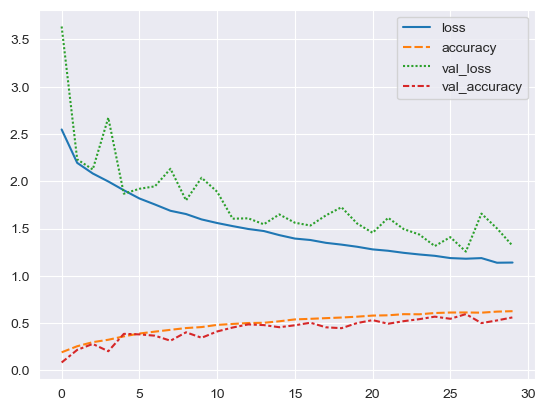

In [24]:
import seaborn as sns
sns.lineplot(data=history.history)

## Hyperparametertuning

In [5]:
def create_model(hp: kt.HyperParameters):
    model = Sequential()

    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    first_filters = hp.Choice('first_filters', values=[16, 32, 64])
    conv_layers = hp.Int('conv_layers', min_value=1, max_value=4, step=1)

    for i in range(conv_layers):
        model.add(Conv2D(filters=2 ** i * first_filters, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(filters=2 ** i * first_filters, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(rate=dropout))

    model.add(Flatten())
    model.add(Dropout(rate=dropout))

    dense_layers = hp.Int('dense_layers', min_value=1, max_value=4, step=1)
    dense_units = hp.Choice('dense_units', values=[64, 128, 256])

    for i in range(dense_layers):
        model.add(Dense(units=dense_units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(rate=dropout))

    model.add(Dense(units=11, activation='softmax'))

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

In [ ]:
import os

tuner = kt.Hyperband(create_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     directory=os.path.normpath('D:/Flo/Python/schule_pos'),
                     project_name='food_classification')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10)
]

tuner.search(train_generator,
             steps_per_epoch=steps_per_epoch,
             epochs=20,
             callbacks=callbacks,
             validation_data=validation_generator,
             validation_steps=validation_steps)

INFO:tensorflow:Reloading Oracle from existing project D:\Flo\Python\schule_pos\food_classification\oracle.json
INFO:tensorflow:Reloading Tuner from D:\Flo\Python\schule_pos\food_classification\tuner0.json

Search: Running Trial #29

Value             |Best Value So Far |Hyperparameter
0.4               |0.3               |dropout
16                |16                |first_filters
4                 |2                 |conv_layers
4                 |2                 |dense_layers
128               |256               |dense_units
10                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/10


In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]

I got a "Dead Kernel" error after more than an hour of finding the best hyperparameters. I just built the cnn with the best values so far.

## Retrainging Model with best Hyperparameters

In [7]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=train_generator.image_shape),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(rate=.3),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(rate=.3),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(rate=.3),
    Flatten(),
    Dropout(rate=.3),
    Dense(units=256, activation='relu'),
    BatchNormalization(),
    Dropout(rate=.3),
    Dense(units=256, activation='relu'),
    BatchNormalization(),
    Dropout(rate=.3),
    Dense(units=11, activation='softmax')
])
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')

In [8]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

callbacks = [
    EarlyStopping(min_delta=.005, monitor='val_accuracy', patience=10, restore_best_weights=True)
]

history = model.fit(train_generator,
                  steps_per_epoch=steps_per_epoch,
                  batch_size=32,
                  epochs=100,
                  workers=-1,
                  validation_data=validation_generator,
                  validation_steps=validation_steps)

Epoch 1/100
247/247 [==============================] - 171s 683ms/step - loss: 2.7736 - accuracy: 0.1507 - val_loss: 2.9879 - val_accuracy: 0.1255
Epoch 2/100
247/247 [==============================] - 35s 143ms/step - loss: 2.3233 - accuracy: 0.2231 - val_loss: 2.4078 - val_accuracy: 0.1819
Epoch 3/100
247/247 [==============================] - 34s 140ms/step - loss: 2.1710 - accuracy: 0.2608 - val_loss: 2.1880 - val_accuracy: 0.2720
Epoch 4/100
247/247 [==============================] - 36s 145ms/step - loss: 2.0601 - accuracy: 0.2935 - val_loss: 2.1190 - val_accuracy: 0.2818
Epoch 5/100
247/247 [==============================] - 35s 142ms/step - loss: 1.9549 - accuracy: 0.3302 - val_loss: 2.0682 - val_accuracy: 0.3089
Epoch 6/100
247/247 [==============================] - 34s 138ms/step - loss: 1.8912 - accuracy: 0.3564 - val_loss: 2.3301 - val_accuracy: 0.2802
Epoch 7/100
247/247 [==============================] - 34s 138ms/step - loss: 1.8077 - accuracy: 0.3834 - val_loss: 3.3326 

Epoch 57/100
247/247 [==============================] - 34s 137ms/step - loss: 0.6824 - accuracy: 0.7719 - val_loss: 1.7156 - val_accuracy: 0.5476
Epoch 58/100
247/247 [==============================] - 34s 137ms/step - loss: 0.6941 - accuracy: 0.7693 - val_loss: 1.6194 - val_accuracy: 0.5574
Epoch 59/100
247/247 [==============================] - 34s 138ms/step - loss: 0.6924 - accuracy: 0.7636 - val_loss: 1.2983 - val_accuracy: 0.6327
Epoch 60/100
247/247 [==============================] - 34s 138ms/step - loss: 0.6778 - accuracy: 0.7762 - val_loss: 1.3500 - val_accuracy: 0.6142
Epoch 61/100
247/247 [==============================] - 34s 136ms/step - loss: 0.6720 - accuracy: 0.7764 - val_loss: 1.3818 - val_accuracy: 0.6189
Epoch 62/100
247/247 [==============================] - 34s 137ms/step - loss: 0.6741 - accuracy: 0.7717 - val_loss: 1.5218 - val_accuracy: 0.5830
Epoch 63/100
247/247 [==============================] - 34s 136ms/step - loss: 0.6582 - accuracy: 0.7850 - val_loss: 1

In [73]:
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


## Testing with own images

In [69]:
labels = ["apple_pie", "cheesecake", "chicken_cury", 
          "french_fries", "fried_rice", "hamburger", "hot_dog", 
          "ice_cream", "omelette", "pizza", "sushi"]
def beautify_prediction(prediction):
    max = 0
    maxIdx = 0
    for idx, i in enumerate(prediction[0]):
        print(f'{labels[idx]:>15s} {i:.2f}')
        if(i > max):
            max = i
            maxIdx = idx
    print("The image contains a " + labels[maxIdx])

In [13]:
def prepare_image(path):
    img = image.load_img(path, target_size=target_size)
    img_array = image.img_to_array(img) / 255
    return np.expand_dims(img_array, axis=0)

In [74]:
img = prepare_image('./data/samuel.png')
beautify_prediction(model.predict(img))

      apple_pie 0.00
     cheesecake 0.01
   chicken_cury 0.00
   french_fries 0.00
     fried_rice 0.00
      hamburger 0.00
        hot_dog 0.00
      ice_cream 0.99
       omelette 0.00
          pizza 0.00
          sushi 0.00
The image contains a ice_cream


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


array([[1.10333815e-01, 8.91587231e-03, 9.98045783e-03, 1.23075632e-04,
        8.09708714e-01, 1.12239400e-06, 6.39501604e-06, 2.50197668e-02,
        1.78759955e-02, 1.74790192e-02, 5.55643870e-04],
       [8.59916091e-01, 1.24089876e-02, 1.31566273e-02, 1.78393489e-03,
        7.19220610e-04, 5.15211083e-04, 2.35024840e-04, 9.26155075e-02,
        1.06109446e-02, 3.08204850e-04, 7.73019018e-03],
       [9.66247618e-01, 6.41271565e-03, 9.06688103e-04, 2.20466027e-05,
        2.20153723e-02, 1.07371070e-05, 7.54245411e-06, 4.37314482e-03,
        2.85862541e-07, 3.17252989e-06, 7.43615942e-07],
       [8.86552513e-01, 1.54158492e-02, 1.09739594e-04, 2.28850491e-04,
        1.59372902e-03, 4.63287272e-02, 1.59043571e-04, 3.85719053e-02,
        5.92595246e-03, 5.52656653e-04, 4.56092088e-03],
       [7.06044137e-01, 1.30266584e-02, 8.99698498e-05, 1.11108860e-02,
        1.94449349e-05, 4.18321251e-05, 8.29997938e-04, 2.68532127e-01,
        2.29072204e-04, 6.81342863e-05, 7.61145702e-